# Library

In [4]:
#Library
import sys
import os
import os.path as pth

#!pip install torchplot
import torch
import torch.nn as nn
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import torch.backends.cudnn as cudnn
import torchplot as plt



import nets
import datasets
import tools
import layers as L
# import train

from io import BytesIO
from datetime import datetime
from pytz import timezone
# from slacker import Slacker
from quantization import *


import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import random
import itertools
import math

from tqdm import tqdm
# from numba import jit

import warnings
warnings.simplefilter("ignore")



# Functions

## Functions - Not Used

In [6]:
# Function for integer operation -> Not completed
# @jit(nopython=True)
def partial_sum_int_fa(original, bit=5):
    a = original
    bit = bit - 2
    result = np.zeros(a.shape[0])
    for d in range(a.shape[0]):
        partial = a[d].sum()
        if partial > 15:
            partial = 15
        elif partial < -15:
            partial = -15
        else:
            partial = partial
        result[d] = math.trunc(partial)
    return result.sum()


# @jit(cache=True)
def conv_custom_fa_int_plot(x_original, w, b):
   
    filt = w.shape[0]
    depth = x_original.shape[0] 
    row = x_original.shape[1] - 2
    col = x_original.shape[2] - 2

    c = np.zeros((filt,row,col))
    one_layer = np.zeros((row,col))
    for f in range(filt):
        for i in range(row):
            for j in range(col):
                r = x_original[:,i:i+3,j:j+3] * w[f]
                one_layer[i,j] = partial_sum_int_fa(r)
        c[f,:,:] = one_layer + b[f]
    return c, one_layer

In [3]:
# Partial_sum_fa_version2 -> Completed & Not used
# @jit(nopython=True)
def partial_sum_fa2(original, bit=5):
    bit = bit - 2
    result = np.zeros(original.shape[0])
    for d in range(original.shape[0]):
        result[d] = original[d].sum()
    result = np.clip(result, -1.875, 1.875)
    for d in range(original.shape[0]):
        result[d] = math.trunc(result[d]* (2**bit)) / (2**bit)
    return result.sum()

In [8]:
# Extra Convolution function - Completed
# @jit(cache=True)
def conv_custom_fa_plot(x_original, w, b):
   
    filt = w.shape[0]
    depth = x_original.shape[0] 
    row = x_original.shape[1] - 2
    col = x_original.shape[2] - 2

    c = np.zeros((filt,row,col))
    one_layer = np.zeros((row,col))
    before_sum = np.zeros((row,col,filt,3,3))
    for f in range(filt):
        for i in range(row):
            for j in range(col):
                r = x_original[:,i:i+3,j:j+3] * w[f]
                #print(r.shape)
                before_sum[i][j][f] = r
                one_layer[i,j] = partial_sum_fa_conv(r)
        c[f,:,:] = one_layer + b[f]
    return c, one_layer, before_sum

# @jit(cache=True)
def conv_custom_fa_test(x_original, w, b):
   
    filt = w.shape[0]
    depth = x_original.shape[0] 
    row = x_original.shape[1] - 2
    col = x_original.shape[2] - 2

    c = np.zeros((filt,row,col))
    one_layer = np.zeros((row,col))
    
    for f in range(filt):
        for i in range(row):
            for j in range(col):
                r = x_original[:,i:i+3,j:j+3] * w[f]
                re = 0
                re1 = partial_sum_fa_conv(r)
                for d1 in range(depth):
                    partial_sum = r[d1].sum()
                    re = re + quant_signed_15_1(partial_sum)
                if (re != re1):
                    print("wrong")
                    print(re, re1)
                    
                one_layer[i,j] = re
        c[f,:,:] = one_layer + b[f]
    return c

# @jit
def quant_signed_15_1(original, bit=5):
    bit = bit -2
    original = np.clip(original, -1.875, 1.875)
    original = original * (2**bit)

    result = math.trunc(original)/ (2**bit)
    return result

In [9]:
# Partial Sum Fast - Completed & Not used
# Fixed point quantization , Not dynamically quantized
# @jit(cache=True)
def partial_sum_fa_fc(original, bit=5):
    a = original
    bit = bit - 2
    result = np.zeros(a.shape[0])
    for d in range(a.shape[0]):
        partial = a[d].sum()
        if partial > 1.875:
            partial = 1.875
        elif partial < -1.875:
            partial = -1.875
        else:
            partial = partial
        result[d] = math.trunc(partial* (2**bit)) / (2**bit)
    return result.sum()

# @jit(nopython=True)
def partial_sum_fa_conv(original, bit=5):
    a = original
    bit = bit - 2
    result = np.zeros(a.shape[0])
    for d in range(a.shape[0]):
        partial = a[d].sum()
        if partial > 1.875:
            partial = 1.875
        elif partial < -1.875:
            partial = -1.875
        else:
            partial = partial
        result[d] = math.trunc(partial* (2**bit)) / (2**bit)
    return result.sum()

In [10]:
# FC & Conv function without point parameters - completed
# Not dynamically quantized
# @jit(cache=True)
def fc_fa_non(x_original, w, b):
   
    filt = w.shape[0]
    stage = int(x_original.shape[1]/8)
    c = np.zeros((1,filt))
    for f in range(filt):
        re = 0
        for i in range(stage):
            r = x_original[0,i*8:i*8+8] * w[f,i*8:i*8+8]
            re = re + r.sum()
        c[0,f] = quant_signed_15_np_fc(re + b[f])
    return c

# @jit(cache=True)
def conv_custom_fa_non(x_original, w, b):
   
    filt = w.shape[0]
    depth = x_original.shape[0] 
    row = x_original.shape[1] - 2
    col = x_original.shape[2] - 2

    c = np.zeros((filt,row,col))
    one_layer = np.zeros((row,col))
    
    for f in range(filt):
        for i in range(row):
            for j in range(col):
                r = x_original[:,i:i+3,j:j+3] * w[f]
                one_layer[i,j] = r.sum()
        c[f,:,:] = quant_signed_15_np(one_layer + b[f])
    return c

## Functions - Valid

In [12]:
# Custom functions - Completed

# @jit
def amac(x, w):
    return (x * b).sum()


# @jit
def reul(x):
    return np.maximum(0,x)


# @jit
def padding(a):
    result = np.zeros((a.shape[0],a.shape[1]+2,a.shape[2]+2))
    for i in range(a.shape[0]):
        result[i] = np.pad(a[i],1)
    return result


# @jit(nopython=True)
def maxpooling(x_original):
   
    depth = x_original.shape[0] 
    row = int((x_original.shape[1])/2)
    col = int((x_original.shape[2])/2)

    one_layer = np.zeros((depth,row,col))
    
    for d in range(depth):
        for i in range(row):
            for j in range(col):
                r = x_original[d,2*i:2*i+2,2*j:2*j+2].max()
                one_layer[d,i,j] = r
    return one_layer


# @jit(nopython=True)
def quant_signed_15_np(original, bit=5):
    bit = bit -2
    original = np.clip(original, -1.875, 1.875)
    original = original * (2**bit)
    
    (row, col) = original.shape
    result = np.zeros((row,col))
    for i in range(row):
        for j in range(col):
            result[i,j] = math.trunc(original[i,j])/ (2**bit)
    return result

# @jit
def quant_signed_15_np_fc(original, bit=5):
    bit = bit -2
    original = np.clip(original, -1.875, 1.875)
    original = original * (2**bit)
    
    result = math.trunc(original)/ (2**bit)
    return result


get_bin = lambda x, n: format(x, 'b').zfill(n).replace("-","1")

In [48]:
# Partial sum function with point parameters - Completed
# @jit(cache=True)
def partial_sum_fa_conv_point(original, bit=5, point = 1):
    a = original
    bit = bit - 2  + (point - 1)
    value = 1.875/(2**(point-1))
    
    result = np.zeros(a.shape[0])
    for d in range(a.shape[0]):
        partial = a[d].sum()
        if partial > value:
            partial = value
        elif partial < -value:
            partial = -value
        else:
            partial = partial
        result[d] = math.trunc(partial* (2**bit)) / (2**bit)
    return result.sum()


# @jit(cache=True)
def partial_sum_fa_fc_point(original, bit=5, point=1):
    a = original
    bit = bit - 2  + (point - 1)
    value = 1.875/(2**(point-1))
    
    partial = a.sum()
    if partial > value:
        partial = value
    elif partial < -value:
        partial = -value
    else:
        partial = partial
    result = math.trunc(partial* (2**bit)) / (2**bit)
    return result

In [49]:
# FC & Conv function with point parameters - completed
# @jit(cache=True)
def fc_fa(x_original, w, b, p=1):
   
    filt = w.shape[0]
    stage = int(x_original.shape[1]/8)
    c = np.zeros((1,filt))
    for f in range(filt):
        re = 0
        for i in range(stage):
            r = x_original[0,i*8:i*8+8] * w[f,i*8:i*8+8]
            re = re + partial_sum_fa_fc_point(r, point=p)
        c[0,f] = quant_signed_15_np_fc(re + b[f])
    return c

# @jit(cache=True)
def conv_custom_fa(x_original, w, b, p=1):
   
    filt = w.shape[0]
    depth = x_original.shape[0] 
    row = x_original.shape[1] - 2
    col = x_original.shape[2] - 2

    c = np.zeros((filt,row,col))
    one_layer = np.zeros((row,col))
    
    for f in range(filt):
        for i in range(row):
            for j in range(col):
                r = x_original[:,i:i+3,j:j+3] * w[f]
                one_layer[i,j] = partial_sum_fa_conv_point(r, point=p)
        c[f,:,:] = quant_signed_15_np(one_layer + b[f])
    return c

In [15]:
# FC & Conv function with point parameters - completed
# @jit(cache=True)
def fc_fa_wo_quant(x_original, w, b, p=1):
   
    filt = w.shape[0]
    stage = int(x_original.shape[1]/8)
    c = np.zeros((1,filt))
    for f in range(filt):
        re = 0
        for i in range(stage):
            r = x_original[0,i*8:i*8+8] * w[f,i*8:i*8+8]
            re = re + partial_sum_fa_fc_point(r, point=p)
        c[0,f] = re + b[f]
    return c

# @jit(cache=True)
def conv_custom_fa_wo_quant(x_original, w, b, p=1):
   
    filt = w.shape[0]
    depth = x_original.shape[0] 
    row = x_original.shape[1] - 2
    col = x_original.shape[2] - 2

    c = np.zeros((filt,row,col))
    one_layer = np.zeros((row,col))
    
    for f in range(filt):
        for i in range(row):
            for j in range(col):
                r = x_original[:,i:i+3,j:j+3] * w[f]
                one_layer[i,j] = partial_sum_fa_conv_point(r, point=p)
        c[f,:,:] = one_layer + b[f]
    return c

# Plot

In [19]:
# Load pretrained model and data

file = open('latest.txt' , 'r' )
line = file.readline()
pretrained_checkpoint = line
file.close()

# Default settings for arch, dataset, and checkpoint
arch = "CNN_627_large"
dataset = "cifar10"
batch_size = 256
pretrained_checkpoint = pretrained_checkpoint

trainloader, _, testloader = datasets.get_mnist(batch_size)
model = nets.mnist_quant()

pretrained_ckpt = torch.load(pretrained_checkpoint, map_location=torch.device('cpu'))
model.load_state_dict(pretrained_ckpt['state_dict'])
print("########## Loaded checkpoint '{}'".format(pretrained_checkpoint))

print("mnist dataset")
with open("./data_quantized/quant_test_data_mnist.pkl","rb") as f:
    data_list = pickle.load(f)
with open("./data_quantized/quant_test_label_mnist.pkl","rb") as g:
    label_list = pickle.load(g)
    
    
# Load Weights and biases
w1 = model.conv1.weight
b1 = model.conv1.bias

w2 = model.conv2.weight
b2 = model.conv2.bias

w3 = model.conv3.weight
b3 = model.conv3.bias

w4 = model.conv4.weight
b4 = model.conv4.bias

w5 = model.fc5.weight
b5 = model.fc5.bias

w6 = model.fc6.weight
b6 = model.fc6.bias


w1 = w1.data.numpy()
b1 = b1.data.numpy()

w2 = w2.data.numpy()
b2 = b2.data.numpy()

w3 = w3.data.numpy()
b3 = b3.data.numpy()

w4 = w4.data.numpy()
b4 = b4.data.numpy()

w5 = w5.data.numpy()
b5 = b5.data.numpy()

w6 = w6.data.numpy()
b6 = b6.data.numpy()

Loading MNIST data ... 
Quant MNIST
########## Loaded checkpoint './checkpoints_quant/mnist_quant_mnist/2_18_Time_16_36/checkpoint_7_98.3.tar'
mnist dataset


In [20]:
i = 0
y = label_list[i]
x_original = data_list[i].view(1,32,32).numpy()

a, b, c = conv_custom_fa_plot(x_original,w1,b1)

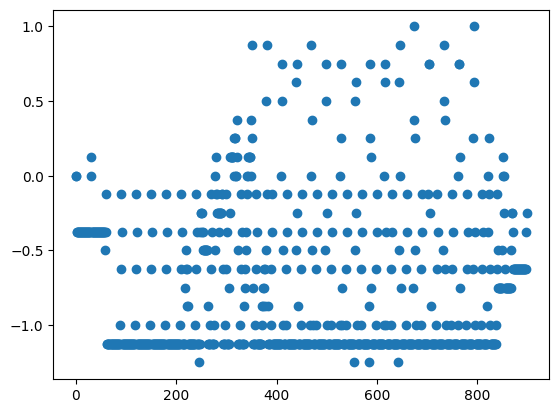

In [21]:
plt.scatter(range(len(b.flatten())),b.flatten())

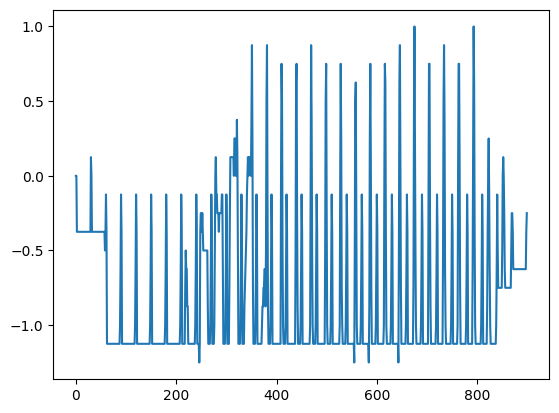

In [22]:
plt.plot(b.flatten())

# Open model and file

## Save the data

In [23]:
# MNIST
batch_size=256
distributed=None
trainsampler = None
workers=2

print("Loading MNIST data ... ")
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./MNIST', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=(trainsampler is None), 
              num_workers=workers, pin_memory=True, sampler=trainsampler)

val_transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.5,), (0.5,))])
testset = torchvision.datasets.MNIST(root='./MNIST', train=False, download=True, transform=val_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=50, shuffle=False, num_workers=workers, pin_memory=True)

# Saving Data

# Padding
m = nn.ConstantPad2d(2, 0)


# Save train data
data_train = trainset.train_data
label_train = trainset.train_labels

data_train = (data_train.int()-128)/128
data_train = quant_signed_15(data_train)
data_train = m(data_train)

with open("./data_quantized/quant_data_mnist.pkl","wb") as f:
    pickle.dump(data_train, f)
with open("./data_quantized/quant_label_mnist.pkl","wb") as g:
    pickle.dump(label_train, g)
    
    
# Save test data
label = testset.test_labels
data = testset.test_data

data = (data.int()-128)/128
data = quant_signed_15(data)
data = m(data)

with open("./data_quantized/quant_test_data_mnist.pkl","wb") as f:
    pickle.dump(data, f)
with open("./data_quantized/quant_test_label_mnist.pkl","wb") as g:
    pickle.dump(label, g)


Loading MNIST data ... 


In [98]:
# Load pretrained model and data

file = open('latest.txt' , 'r' )
line = file.readline()
pretrained_checkpoint = line
file.close()

# Default settings for arch, dataset, and checkpoint
arch = "CNN_627_large"
dataset = "cifar10"
batch_size = 256
pretrained_checkpoint = pretrained_checkpoint

trainloader, _, testloader = datasets.get_mnist(batch_size)
model = nets.mnist_quant()

pretrained_ckpt = torch.load(pretrained_checkpoint, map_location=torch.device('cpu'))
model.load_state_dict(pretrained_ckpt['state_dict'])
print("########## Loaded checkpoint '{}'".format(pretrained_checkpoint))

print("mnist dataset")
with open("./data_quantized/quant_test_data_mnist.pkl","rb") as f:
    data_list = pickle.load(f)
with open("./data_quantized/quant_test_label_mnist.pkl","rb") as g:
    label_list = pickle.load(g)
    
    
# Load Weights and biases
w1 = model.conv1.weight
b1 = model.conv1.bias

w2 = model.conv2.weight
b2 = model.conv2.bias

w3 = model.conv3.weight
b3 = model.conv3.bias

w4 = model.conv4.weight
b4 = model.conv4.bias

w5 = model.fc5.weight
b5 = model.fc5.bias

w6 = model.fc6.weight
b6 = model.fc6.bias


w1 = w1.data.numpy()
b1 = b1.data.numpy()

w2 = w2.data.numpy()
b2 = b2.data.numpy()

w3 = w3.data.numpy()
b3 = b3.data.numpy()

w4 = w4.data.numpy()
b4 = b4.data.numpy()

w5 = w5.data.numpy()
b5 = b5.data.numpy()

w6 = w6.data.numpy()
b6 = b6.data.numpy()

Loading MNIST data ... 
Quant MNIST
########## Loaded checkpoint './checkpoints_quant/mnist_quant_mnist/2_18_Time_16_36/checkpoint_7_98.3.tar'
mnist dataset


# Save weight

## Save weight of first conv

In [26]:
file = open('./data_extracted/conv1_weight_0311.txt','w')

a = w1
a = a * 16
for d in range(a.shape[1]):
    for f in range(a.shape[0]):
        for i in range(3):
            for j in range(3):
                file.write(get_bin(int(a[f,d,i,j]),5)+"\n")
file.close()

## Save weight of second conv

In [27]:
file = open('./data_extracted/conv2_weight_0311.txt','w')

a = w2
a = a * 16
for d in range(a.shape[1]):
    for f in range(a.shape[0]):
        for i in range(3):
            for j in range(3):
                file.write(get_bin(int(a[f,d,i,j]),5)+"\n")
file.close()

## Save weight of thrid conv

In [28]:
file = open('./data_extracted/conv3_weight_0311.txt','w')

a = w3
a = a * 16
for d in range(a.shape[1]):
    for f in range(a.shape[0]):
        for i in range(3):
            for j in range(3):
                file.write(get_bin(int(a[f,d,i,j]),5)+"\n")
file.close()

## Save weight of fourth conv

In [29]:
file = open('./data_extracted/conv4_weight_0311.txt','w')

a = w4
a = a * 16
for d in range(a.shape[1]):
    for f in range(a.shape[0]):
        for i in range(3):
            for j in range(3):
                file.write(get_bin(int(a[f,d,i,j]),5)+"\n")
file.close()

## Save weight of fifth fc

In [30]:
print(w5.shape)

(32, 1024)


In [31]:
file = open('./data_extracted/fc5_weight_0311.txt','w')

a = w5
a = a * 16
for d in range(a.shape[1]):
    for f in range(a.shape[0]):
        for i in range(3):
            for j in range(3):
                file.write(get_bin(int(a[f,d,i,j]),5)+"\n")
file.close()

IndexError: too many indices for array: array is 2-dimensional, but 4 were indexed

In [32]:
file = open('./data_extracted/fc5_weight_0311.txt','w')

weight = w5*16

for w in range(0, weight.shape[0], 32):
    for mac in range(min(weight.shape[0] - w, 32)):
#             file.write(get_bin(int(bias[w+mac]),5)+"\n")
        file.write("0\n")
    for z in range(0, weight.shape[1], 8):
        for mac in range(min(weight.shape[0] - w, 32)):
            for port in range(8):
                file.write(get_bin(int(weight[w+mac,z+port]),5)+"\n")
                
file.close()

## Save weight of sixth fc

In [33]:
print(w6.shape)

(10, 32)


In [34]:
file = open('./data_extracted/fc6_weight_0311.txt','w')

a = w6
a = a * 16
for d in range(a.shape[1]):
    for f in range(a.shape[0]):
        for i in range(3):
            for j in range(3):
                file.write(get_bin(int(a[f,d,i,j]),5)+"\n")
file.close()

IndexError: too many indices for array: array is 2-dimensional, but 4 were indexed

In [35]:
file = open('./data_extracted/fc6_weight_0311.txt','w')

weight = w6*16

for w in range(0, weight.shape[0], 32):
    for mac in range(min(weight.shape[0] - w, 32)):
#             file.write(get_bin(int(bias[w+mac]),5)+"\n")
        file.write("0\n")
    for z in range(0, weight.shape[1], 8):
        for mac in range(min(weight.shape[0] - w, 32)):
            for port in range(8):
                file.write(get_bin(int(weight[w+mac,z+port]),5)+"\n")
                
file.close()

# Save bias

In [36]:
b1.shape
file = open('./data_extracted/conv1_bias_0311.txt','w')

a = b1
a = a * 16
for i in range(a.shape[0]):
    file.write(get_bin(int(a[i]),5)+"\n")
file.close()

# Test

## Input

In [106]:
i = 0
y = label_list[i]
x_original = data_list[i].view(1,32,32).numpy()

## Input save

In [107]:
file = open('./data_extracted/suite1/input.txt','w')
# x_original = torch.randn(1, 32,32)
x_original = data_list[0].view(1,32,32)
print((x_original == quant_signed_15(x_original)).sum())
x_original = quant_signed_15(x_original)

x = x_original
x = x*8
print(x.shape)


for d in range(x.shape[0]):
    for i in range(x.shape[1]):
        for j in range(x.shape[2]):
            file.write(get_bin(int(x[d,i,j]),5)+"\n")
file.close()

tensor(1024)
torch.Size([1, 32, 32])


## First conv result save

In [108]:
# b1 = np.zeros(32)
x = x_original
x = padding(x)
#x = conv_custom_fa_wo_quant(x,w1,b1)
x = conv_custom_fa(x,w1,b1, p=1)

## First relu&pool result save

In [109]:
x = reul(maxpooling(x))

file = open('./data_extracted/suite1/pool1_output.txt','w')

save = x*8
for d in range(x.shape[0]):
    for i in range(x.shape[1]):
        for j in range(x.shape[2]):
            #print(x[d,i,j])
            file.write(get_bin(int(save[d,i,j]),5)+"\n")
file.close()

## Second conv result save

In [110]:
print(x.shape)
# b2 = np.zeros(64)
x = padding(x)
x = conv_custom_fa(x,w2,b2, p=1)


(32, 16, 16)


## Second relu & pool result save

In [111]:
x = reul(maxpooling(x))

file = open('./data_extracted/pool2_output.txt','w')

save = x*8
for d in range(x.shape[0]):
    for i in range(x.shape[1]):
        for j in range(x.shape[2]):
            #print(x[d,i,j])
            file.write(get_bin(int(save[d,i,j]),5)+"\n")
file.close()

## Thrid conv result save

In [112]:
print(x.shape)
# b3 = np.zeros(128)
x = padding(x)
x = conv_custom_fa(x,w3,b3, p=1)

(64, 8, 8)


## Thrid pool & relu result save

In [113]:
x = reul(maxpooling(x))

file = open('./data_extracted/pool3_output.txt','w')

save = x*8
for d in range(x.shape[0]):
    for i in range(x.shape[1]):
        for j in range(x.shape[2]):
            #print(x[d,i,j])
            file.write(get_bin(int(save[d,i,j]),5)+"\n")
file.close()

## Fourth conv result save

In [114]:
print(x.shape)
# b4 = np.zeros(256)
x = padding(x)
x = conv_custom_fa(x,w4,b4, p=1)

(128, 4, 4)


## Fourth pool & relu result save

In [115]:
x = reul(maxpooling(x))

file = open('./data_extracted/pool4_output.txt','w')

save = x*8
for d in range(x.shape[0]):
    for i in range(x.shape[1]):
        for j in range(x.shape[2]):
            #print(x[d,i,j])
            file.write(get_bin(int(save[d,i,j]),5)+"\n")
file.close()

## Fifth fc result save

In [88]:
print(x.shape)
x = x.reshape(1,1024)
print(x.shape)

(256, 2, 2)
(1, 1024)


In [116]:
print(x.shape)
# b5 = np.zeros(32)

x = fc_fa(x,w5,b5, p=1)
print(x.shape)

(256, 2, 2)
(1, 32)


## Fifth relu result save

In [117]:
x = reul(x)

file = open('./data_extracted/relu5_output.txt','w')

save = x*8
for d in range(x.shape[1]):
    file.write(get_bin(int(save[0,d]),5)+"\n")
file.close()

## Sixth fc result save

In [118]:
print(x.shape)
# b6 = np.zeros(10)

x = fc_fa(x,w6,b6, p=1)

(1, 32)


In [119]:
x = reul(x)

file = open('./data_extracted/relu6_output.txt','w')

save = x*8
for d in range(x.shape[1]):
    #print(x[d,i,j])
    file.write(get_bin(int(save[0,d]),5)+"\n")
file.close()

# Need to organize

(array([5876.,  684.,  668.,  208.,  421.,   83.,   88.,   68.,   59.,
          37.]),
 array([0.    , 0.1875, 0.375 , 0.5625, 0.75  , 0.9375, 1.125 , 1.3125,
        1.5   , 1.6875, 1.875 ]),
 <BarContainer object of 10 artists>)

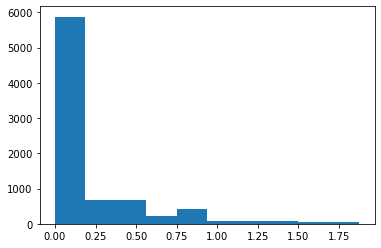

In [537]:
plt.hist(x.flatten())

(64, 8, 8)


(array([3.574e+03, 2.510e+02, 1.540e+02, 4.900e+01, 3.100e+01, 1.600e+01,
        9.000e+00, 6.000e+00, 5.000e+00, 1.000e+00]),
 array([0.    , 0.3125, 0.625 , 0.9375, 1.25  , 1.5625, 1.875 , 2.1875,
        2.5   , 2.8125, 3.125 ]),
 <BarContainer object of 10 artists>)

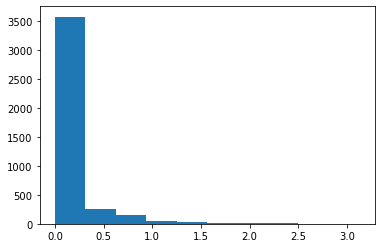

In [528]:
x = maxpooling(x)
x = reul(x)
print(x.shape)
plt.hist(x.flatten())

In [529]:
print(x.shape)
b3 = np.zeros(128)
x = padding(x)
x, mid = conv_custom_fa_plot(x,w3,b3)

(64, 8, 8)


In [310]:
x = maxpooling(x)
x = reul(x)

x = padding(x)
x = conv_custom_fa_test(x,w4,b4)
x = maxpooling(x)
x = reul(x)

In [ ]:
print("mnist dataset")
with open("./data_quantized/quant_data_mnist.pkl","rb") as f:
    data_list = pickle.load(f)
with open("./data_quantized/quant_label_mnist.pkl","rb") as g:
    label_list = pickle.load(g)

In [24]:
file = open('./data_extracted/input.txt','w')
# x_original = torch.randn(1, 32,32)
x_original = data_list[0].view(1,32,32)
print((x_original == quant_signed_15(x_original)).sum())
x_original = quant_signed_15(x_original)

x = x_original
x = x*8
print(x.shape)


for d in range(x.shape[0]):
    for i in range(x.shape[1]):
        for j in range(x.shape[2]):
            file.write(get_bin(int(x[d,i,j]),5)+"\n")
file.close()

tensor(1024)
torch.Size([1, 32, 32])


In [25]:
print("--------------shape----------------")
print(x_original.shape)

x = x_original.numpy()
x = padding(x)

result_original = conv_custom_fa(x, w1, b1)
result = result_original*8


print(result_original.shape)
print(sum(sum(sum(result >= 16))))

file = open('./data_extracted/output/conv1_output.txt','w')

x = result
for d in range(x.shape[0]):
    for i in range(x.shape[1]):
        for j in range(x.shape[2]):
            #print(x[d,i,j])
            file.write(get_bin(int(x[d,i,j]),5)+"\n")
file.close()

--------------shape----------------
torch.Size([1, 32, 32])
(32, 32, 32)
0


In [548]:
x = maxpooling(x)
x = reul(x)

In [ ]:
file = open('./data_extracted/output/acc1__custom_output.txt','w')

save = mid*8
for d in range(x.shape[0]):
    for i in range(x.shape[1]):
        for j in range(x.shape[2]):
            #print(x[d,i,j])
            file.write(get_bin(int(save[d,i,j]),10)+"\n")
file.close()

In [124]:
x = x_original
print(x.shape)
b1 = np.zeros(32)
x = padding(x)
x, mid, before_sum = conv_custom_fa_plot(x,w1,b1)
plt.hist(x.flatten())

(1, 32, 32)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3

(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)


(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)


(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)


(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)


(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)


(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)


(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)


(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)


(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)


(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)
(1, 3, 3)


(array([ 1152.,  1444.,  2771.,  6225.,  6280., 11181.,  2079.,  1197.,
          294.,   145.]),
 array([-1.875, -1.5  , -1.125, -0.75 , -0.375,  0.   ,  0.375,  0.75 ,
         1.125,  1.5  ,  1.875]),
 <BarContainer object of 10 artists>)

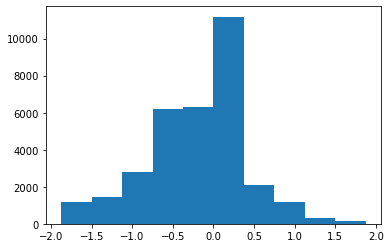

(array([503.,  54.,  93., 117.,  20., 178.,  27.,  10.,  15.,   7.]),
 array([-1.25 , -1.025, -0.8  , -0.575, -0.35 , -0.125,  0.1  ,  0.325,
         0.55 ,  0.775,  1.   ]),
 <BarContainer object of 10 artists>)

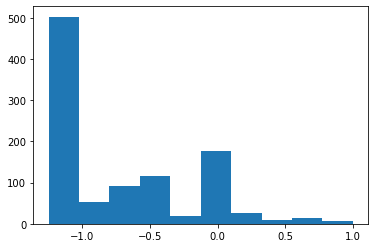

In [550]:
plt.hist(mid.flatten())

# Test One Shot

In [15]:
# Load pretrained model and data

file = open('latest.txt' , 'r' )
line = file.readline()
pretrained_checkpoint = line
file.close()

# Default settings for arch, dataset, and checkpoint
arch = "CNN_627_large"
dataset = "cifar10"
batch_size = 256
pretrained_checkpoint = pretrained_checkpoint

trainloader, _, testloader = datasets.get_mnist(batch_size)
model = nets.mnist_quant()

pretrained_ckpt = torch.load(pretrained_checkpoint)
model.load_state_dict(pretrained_ckpt['state_dict'])
print("########## Loaded checkpoint '{}'".format(pretrained_checkpoint))

print("mnist dataset")
with open("./data_quantized/quant_test_data_mnist.pkl","rb") as f:
    data_list = pickle.load(f)
with open("./data_quantized/quant_test_label_mnist.pkl","rb") as g:
    label_list = pickle.load(g)
    
    
# Load Weights and biases
w1 = model.conv1.weight
b1 = model.conv1.bias

w2 = model.conv2.weight
b2 = model.conv2.bias

w3 = model.conv3.weight
b3 = model.conv3.bias

w4 = model.conv4.weight
b4 = model.conv4.bias

w5 = model.fc5.weight
b5 = model.fc5.bias

w6 = model.fc6.weight
b6 = model.fc6.bias


w1 = w1.data.numpy()
b1 = b1.data.numpy()

w2 = w2.data.numpy()
b2 = b2.data.numpy()

w3 = w3.data.numpy()
b3 = b3.data.numpy()

w4 = w4.data.numpy()
b4 = b4.data.numpy()

w5 = w5.data.numpy()
b5 = b5.data.numpy()

w6 = w6.data.numpy()
b6 = b6.data.numpy()

Loading MNIST data ... 
Quant MNIST
########## Loaded checkpoint './checkpoints_quant/mnist_quant_mnist/2_18_Time_16_36/checkpoint_7_98.3.tar'
mnist dataset


## Custom model

In [16]:
# Evaluate with Custom model
correct = 0
for i in range(256):

    y = label_list[i]

    x = data_list[i].view(1,32,32).numpy()

    x = padding(x)
    x = conv_custom_fa(x,w1,b1, p=1)
    x = maxpooling(x)
    x = reul(x)

    x = padding(x)
    x = conv_custom_fa(x,w2,b2, p=2)
    x = maxpooling(x)
    x = reul(x)

    x = padding(x)
    x = conv_custom_fa(x,w3,b3, p=3)
    x = maxpooling(x)
    x = reul(x)

    x = padding(x)
    x = conv_custom_fa(x,w4,b4, p=2)
    x = maxpooling(x)
    x = reul(x)

    x = x.reshape(1,1024)

    x = fc_fa(x,w5,b5, p=3)
    x = reul(x)

    x = fc_fa(x,w6,b6, p=3)


    if (np.argmax(x) == y.item()):
        correct += 1

print(correct/(i+1))

0.8515625


## Torch model

In [607]:
# Evaluate with Torch model
correct = 0
for i in range(1000):    
    y = label_list[i]
    x = data_list[i].view(1,32,32)
    
    x = model.conv1(x)
    x = model.pool1(F.relu(x))
    x = quant_signed_15(x)

    x = model.conv2(x)
    x = model.pool2(F.relu(x))
    x = quant_signed_15(x)

    x = model.conv3(x)
    x = model.pool3(F.relu(x))
    x = quant_signed_15(x)


    x = model.conv4(x)
    x = model.pool4(F.relu(x))
    x = quant_signed_15(x)


    x = x.view(1,-1)
    x = model.fc5(x)
    x = quant_signed_15(x)
    x = F.relu(x)

    x = model.fc6(x)
    x = quant_signed_15(x)

    index_min1 = np.argmax(x.detach().numpy())
    if (index_min1 == y.item()):
        correct += 1
print(correct/i)

0.987987987987988


## Compar the result of two model

In [488]:
# Start compare

# Custom model
i = 10
x = data_list[i].view(1,32,32).numpy()

x = padding(x)
x = conv_custom_fa(x,w1,b1)
x = maxpooling(x)
x = reul(x)

x = padding(x)
x = conv_custom_fa(x,w2,b2)
x = maxpooling(x)
x = reul(x)

x = padding(x)
x = conv_custom_fa(x,w3,b3)
x = maxpooling(x)
x = reul(x)

x = padding(x)
x = conv_custom_fa(x,w4,b4)
x = maxpooling(x)
x = reul(x)

x = x.reshape(1,1024)

x = fc_fa(x,w5,b5)

x1 = x

# Torch model

x = data_list[i].view(1,32,32)

x = model.conv1(x)
x = model.pool1(F.relu(x))

x = model.conv2(x)
x = model.pool2(F.relu(x))

x = model.conv3(x)
x = model.pool3(F.relu(x))


x = model.conv4(x)
x = model.pool4(F.relu(x))

x = x.view(1,-1)

x = model.fc5(x)

x2 = x

print(x1.shape, x2.shape)

if len(x1.shape) == 3:
    print("Conv Layer")
    a = x.shape[0]
    b = x.shape[1]
    c = x.shape[2]


    for i in range(a):
        for j in range(b):
            for k in range(c):
                if (x1[i][j][k] == x2[i][j][k].item()) == False:
                    print(x1[i][j][k] == x2[i][j][k].item())
                else:
                    print("Good")
elif len(x1.shape) == 2:
    print("FC Layer")
    a = x.shape[0]
    b = x.shape[1]

    for i in range(a):
        for j in range(b):
            if (x1[i][j] == x2[i][j].item()) == False:
                print(x1[i][j] ,x2[i][j].item())
            else:
                print("Good")

(1, 32) torch.Size([1, 32])
